In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
%matplotlib inline

In [153]:
midterm = pd.read_csv('midterm.csv')
kaggle = pd.read_csv('twitter_human_bots_dataset.csv', index_col=0)

In [154]:
midterm.head(2)

,probe_timestamp,user_id,screen_name,name,description,user_created_at,url,lang,protected,verified,...,profile_use_background_image,default_profile,followers_count,friends_count,listed_count,favourites_count,statuses_count,tid,tweet_ids,account_type
0,Tue Nov 06 20:35:08 2018,4107317134,danitheduck21,Dani🏳️‍🌈,Dani 💜 She/Her 💜 Randomness all over. Expect l...,2015-11-03 21:16:13,NaN,en,0.0,False,...,False,False,481,870,26,6542,67025,1059907055421509632,4107317134,human
1,Tue Nov 06 17:57:51 2018,4858296837,ncaraballoPR,Natalie Caraballo,"Things I don’t get tired of: Politics, Amy Win...",2016-01-28 20:03:51,NaN,en,0.0,False,...,False,False,202,712,5,1515,158,1059867472810180609,4858296837,human


In [155]:
kaggle.head(2)

,created_at,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,location,profile_background_image_url,profile_image_url,screen_name,statuses_count,verified,average_tweets_per_day,account_age_days,account_type
0,15/10/2016 21:32,False,False,"Blame @xaiax, Inspired by @MakingInvisible, us...",4,1589,4,False,7.874060e+17,en,unknown,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/7874121826...,best_in_dumbest,11041,False,7.870,1403,bot
1,09/11/2016 5:01,False,False,Photographing the American West since 1980. I ...,536,860,880,False,7.962160e+17,en,Estados Unidos,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/8023296328...,CJRubinPhoto,252,False,0.183,1379,human


In [156]:
midterm['probe_timestamp'] = pd.to_datetime(midterm['probe_timestamp'])
midterm['user_created_at'] = pd.to_datetime(midterm['user_created_at'])
kaggle['created_at'] = pd.to_datetime(kaggle['created_at'])

In [157]:
midterm['account_age_days'] = (midterm['probe_timestamp'] - midterm['user_created_at']).dt.days

In [158]:
# drop unrelated columns
midterm.drop(columns=['probe_timestamp', 'name', 'url', 'protected', 'listed_count', 'tid', 'tweet_ids'], inplace=True)

In [159]:
# drop columns not used in building the model
midterm.drop(columns=['user_id', 'screen_name', 'lang'], inplace=True)
kaggle.drop(columns=['default_profile_image', 'id', 'lang', 'location', 'profile_image_url', 'screen_name'], inplace=True)

In [160]:
kaggle.drop('average_tweets_per_day', axis=1, inplace=True)

In [161]:
# rename columns for both datasets so they have matching columns
midterm.rename(columns={'user_created_at': 'created_at', 'profile_use_background_image': 'profile_background_image_url'}, inplace=True)

In [162]:
# Refactor profile_background_image_url before .concat to prevent problems I haven't seen yet
kaggle["profile_background_image_url"] = kaggle["profile_background_image_url"].notnull().astype("int")
midterm['profile_background_image_url'].replace([True, False], [1, 0], inplace=True)

**Join the two tables together!!!**

In [163]:
df = pd.concat([kaggle, midterm])

In [164]:
df['created_at_day'] = df.created_at.dt.day
df['created_at_month'] = df.created_at.dt.month
df['created_at_year'] = df.created_at.dt.year

In [165]:
# drop created_at column
df.drop('created_at', axis=1, inplace=True)

**Make columns Machine Learning ready**

In [166]:
df['default_profile'].replace([True, False], [1, 0], inplace=True)
df["description"] = df["description"].notnull().astype("int")
df['geo_enabled'].replace([True, False], [1, 0], inplace=True)
df['verified'].replace([True, False], [1, 0], inplace=True)

In [167]:
df['account_type'].replace(['human', 'bot'], [1, 0], inplace=True)

Cant forget to drop duplicates.

In [168]:
df = df.drop_duplicates()

## Machine Learning

In [169]:
from sklearn.model_selection import train_test_split # splitting the data
from sklearn.preprocessing import StandardScaler # normalizing the data
from sklearn.preprocessing import MinMaxScaler # normalizing the data
from sklearn.model_selection import KFold # use for cross validation
from sklearn.model_selection import GridSearchCV # tuning model parameters
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.tree import DecisionTreeClassifier # Decision trees
from sklearn.naive_bayes import GaussianNB # Naive Bayes
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # Accuracy metrics

In [170]:
df.sample(5)

,default_profile,description,favourites_count,followers_count,friends_count,geo_enabled,profile_background_image_url,statuses_count,verified,account_age_days,account_type,created_at_day,created_at_month,created_at_year
23735,0,0,19963,1132,743,0,1,48981,0,3143,0,1,11,2012
18622,0,1,1986,144,275,0,1,2652,0,4188,0,3,1,2009
15012,1,1,369,3,139,0,1,251,0,107,0,24,7,2018
36742,0,1,7730,132206,10412,1,1,46430,1,3511,0,1,7,2011
36857,1,1,9988,298,1504,1,1,18354,0,3912,1,12,2,2009


In [171]:
X = df.drop('account_type', axis=1)
y = df['account_type']

In [172]:
# split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [173]:
sc = MinMaxScaler()
col_to_scale = ['followers_count', 'friends_count', 'favourites_count', 'statuses_count', 'account_age_days',
                'created_at_day', 'created_at_month', 'created_at_year']
X_train[col_to_scale] = sc.fit_transform(X_train[col_to_scale])
X_test[col_to_scale] = sc.transform(X_test[col_to_scale])

<ipython-input-173-8806f3e2a1e2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col_to_scale] = sc.fit_transform(X_train[col_to_scale])
C:\Users\ugonn\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-173-8806f3e2a1e2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

## K Nearest Neighbors

In [174]:
# create the model
knn = KNeighborsClassifier(n_neighbors=5)

# fit the model
knn.fit(X_train, y_train)

# predict using unseen data
y_pred = knn.predict(X_test)

clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
print("Test Result:\n================================================")        
print(f"Accuracy Score: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{clf_report}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}\n")

# compare and calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"KNN's accuracy is {accuracy}")

Test Result:
Accuracy Score: 86.26%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy     macro avg  weighted avg
precision     0.885280     0.833608  0.862625      0.859444      0.863066
recall        0.872037     0.850145  0.862625      0.861091      0.862625
f1-score      0.878609     0.841795  0.862625      0.860202      0.862782
support    8690.000000  6553.000000  0.862625  15243.000000  15243.000000
_______________________________________________
Confusion Matrix: 
 [[7578 1112]
 [ 982 5571]]

KNN's accuracy is 0.8626254674276718


**Explaining Confusion Matrix**
* 0,0 - True Negative
* 0,1 - False Positive
* 1,0 - False Negative
* 1,1 - True Positive

## Random Forest

In [175]:
# create the model
rf = RandomForestClassifier()

# fit the model
rf.fit(X_train, y_train)

# predict using unseen data
y_pred = rf.predict(X_test)

clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
print("Test Result:\n================================================")        
print(f"Accuracy Score: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{clf_report}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}\n")

# compare and calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"Random Forest's accuracy is {accuracy}")

Test Result:
Accuracy Score: 93.12%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy     macro avg  weighted avg
precision     0.961585     0.895190  0.931247      0.928388      0.933042
recall        0.915995     0.951473  0.931247      0.933734      0.931247
f1-score      0.938237     0.922474  0.931247      0.930355      0.931460
support    8690.000000  6553.000000  0.931247  15243.000000  15243.000000
_______________________________________________
Confusion Matrix: 
 [[7960  730]
 [ 318 6235]]

Random Forest's accuracy is 0.931247129830086


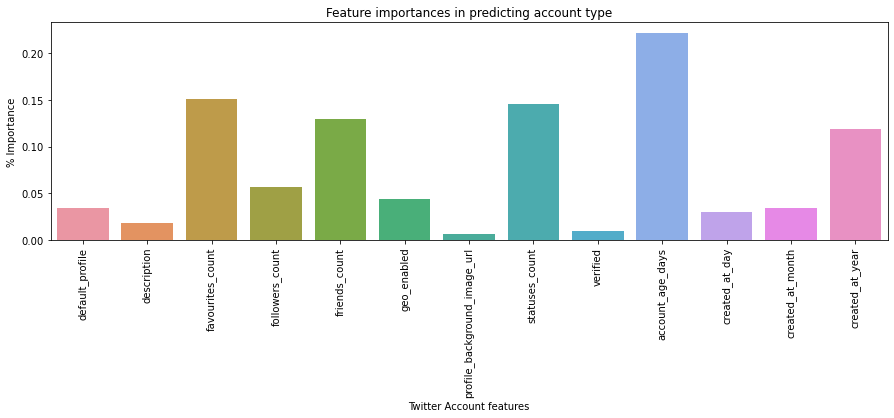

In [176]:
# plot feature importances using random forest method
figure(figsize=(15, 4))

# Plot the result.
sns.barplot(x=X.columns, y=rf.feature_importances_, ci=None);

# labels and title
plt.xticks(rotation=90);
plt.title('Feature importances in predicting account type');
plt.ylabel('% Importance');
plt.xlabel('Twitter Account features');

## Decision Trees

In [177]:
# create the model
dt = DecisionTreeClassifier()

# fit the model
dt.fit(X_train, y_train)

# predict using unseen data
y_pred = dt.predict(X_test)

clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
print("Test Result:\n================================================")        
print(f"Accuracy Score: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{clf_report}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}\n")

# compare and calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"Decision Tree's accuracy is {accuracy}")

Test Result:
Accuracy Score: 90.05%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy     macro avg  weighted avg
precision     0.912963     0.884093  0.900545      0.898528      0.900552
recall        0.912543     0.884633  0.900545      0.898588      0.900545
f1-score      0.912753     0.884363  0.900545      0.898558      0.900548
support    8690.000000  6553.000000  0.900545  15243.000000  15243.000000
_______________________________________________
Confusion Matrix: 
 [[7930  760]
 [ 756 5797]]

Decision Tree's accuracy is 0.9005445122351243


## Naive Bayes

In [178]:
# create the model
gnb = GaussianNB()

# fit the model
gnb.fit(X_train, y_train)

# predict using unseen data
y_pred = gnb.predict(X_test)

clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
print("Test Result:\n================================================")        
print(f"Accuracy Score: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{clf_report}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}\n")

# compare and calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"Naive Bayes' accuracy is {accuracy}")
print(f"Number of correctly labeled points out of a total {X_test.shape[0]} points : {(y_test == y_pred).sum()}")

Test Result:
Accuracy Score: 84.33%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy     macro avg  weighted avg
precision     0.835498     0.855922  0.843338      0.845710      0.844279
recall        0.902992     0.764230  0.843338      0.833611      0.843338
f1-score      0.867935     0.807481  0.843338      0.837708      0.841946
support    8690.000000  6553.000000  0.843338  15243.000000  15243.000000
_______________________________________________
Confusion Matrix: 
 [[7847  843]
 [1545 5008]]

Naive Bayes' accuracy is 0.8433379256051958
Number of correctly labeled points out of a total 15243 points : 12855


# Test with another dataset to confirm accuracy [Celebrity]

In [179]:
celebrity = pd.read_csv('celebrity.csv')

In [180]:
celebrity['created_at'] = pd.to_datetime(celebrity['created_at'])

In [181]:
celebrity.created_at.min(), celebrity.created_at.max()

(Timestamp('2006-10-24 03:32:27+0000', tz='UTC'),
 Timestamp('2017-10-29 13:31:55+0000', tz='UTC'))

In [182]:
celebrity['probe_timestamp'] = '2019-10-27'

In [183]:
celebrity['probe_timestamp'] = pd.to_datetime(celebrity['probe_timestamp'])

In [184]:
celebrity['created_at'] = celebrity['created_at'].dt.date

In [185]:
celebrity['created_at'] = pd.to_datetime(celebrity['created_at'])

In [186]:
celebrity['account_age_days'] = (celebrity['probe_timestamp'] - celebrity['created_at']).dt.days

In [187]:
# drop columns not used in building the model
celebrity.drop(columns=['default_profile_image', 'id', 'lang', 'location', 'profile_image_url',
                        'screen_name', 'probe_timestamp', 'tweet_ids'], inplace=True)

In [188]:
# Refactor profile_background_image_url
celebrity["profile_background_image_url"] = celebrity["profile_background_image_url"].notnull().astype("int")

In [189]:
celebrity['created_at_day'] = celebrity.created_at.dt.day
celebrity['created_at_month'] = celebrity.created_at.dt.month
celebrity['created_at_year'] = celebrity.created_at.dt.year

In [190]:
# drop created_at column
celebrity.drop('created_at', axis=1, inplace=True)

**Make columns Machine Learning ready**

In [191]:
celebrity['default_profile'].replace([True, False], [1, 0], inplace=True)
celebrity["description"] = celebrity["description"].notnull().astype("int")
celebrity['geo_enabled'].replace([True, False], [1, 0], inplace=True)
celebrity['verified'].replace([True, False], [1, 0], inplace=True)

In [192]:
celebrity['account_type'].replace(['human', 'bot'], [1, 0], inplace=True)

In [193]:
celebrity.head()

,default_profile,description,favourites_count,followers_count,friends_count,geo_enabled,profile_background_image_url,statuses_count,verified,account_type,account_age_days,created_at_day,created_at_month,created_at_year
0,0,1,13561,651238,665,0,1,39411,1,1,4100,5,8,2008
1,0,1,11365,265102,943,0,1,41187,1,1,3785,16,6,2009
2,1,1,76,2724932,14,0,1,310,1,1,2089,6,2,2014
3,0,1,111,727503,293,1,1,16689,1,1,3845,17,4,2009
4,0,1,6215,1845847,686,1,1,4977,1,1,3758,13,7,2009


## Machine Learning

In [194]:
X_celebrity = celebrity.drop('account_type', axis=1)
y_celebrity = celebrity['account_type']

In [195]:
col_to_scale = ['followers_count', 'friends_count', 'favourites_count', 'statuses_count', 'account_age_days',
                'created_at_day', 'created_at_month', 'created_at_year']
X_celebrity[col_to_scale] = sc.transform(X_celebrity[col_to_scale])

## KNN

In [200]:
# predict using unseen data
y_pred = knn.predict(X_celebrity)

# compare and calculate accuracy
accuracy = accuracy_score(y_celebrity, y_pred)

print(f"KNN's accuracy is {accuracy}")

KNN's accuracy is 0.9560662385941197


## Random Forest

In [201]:
# predict using unseen data
y_pred = rf.predict(X_celebrity)

# compare and calculate accuracy
accuracy = accuracy_score(y_celebrity, y_pred)

print(f"Random Forest's accuracy is {accuracy}")

Random Forest's accuracy is 0.9947617438323758


## Decision Trees

In [202]:
# predict using unseen data
y_pred = dt.predict(X_celebrity)

# compare and calculate accuracy
accuracy = accuracy_score(y_celebrity, y_pred)

print(f"Decision Tree's accuracy is {accuracy}")

Decision Tree's accuracy is 0.9540385265292328


# Test with another dataset to confirm accuracy [Pronbots]

In [203]:
pronbots = pd.read_csv('pronbots.csv')

In [204]:
pronbots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17882 entries, 0 to 17881
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   created_at                    17882 non-null  object
 1   default_profile               17882 non-null  bool  
 2   default_profile_image         17882 non-null  bool  
 3   description                   17807 non-null  object
 4   favourites_count              17882 non-null  int64 
 5   followers_count               17882 non-null  int64 
 6   friends_count                 17882 non-null  int64 
 7   geo_enabled                   17882 non-null  bool  
 8   id                            17882 non-null  int64 
 9   lang                          17882 non-null  object
 10  location                      3032 non-null   object
 11  profile_background_image_url  16337 non-null  object
 12  profile_image_url             17880 non-null  object
 13  screen_name     

In [205]:
pronbots['created_at'] = pd.to_datetime(pronbots['created_at'])

In [206]:
pronbots.created_at.min(), pronbots.created_at.max()

(Timestamp('2007-06-20 05:10:39+0000', tz='UTC'),
 Timestamp('2018-03-07 19:09:23+0000', tz='UTC'))

In [207]:
pronbots['probe_timestamp'] = '2019-05-13'

In [208]:
pronbots['probe_timestamp'] = pd.to_datetime(pronbots['probe_timestamp'])

In [209]:
pronbots['created_at'] = pronbots['created_at'].dt.date

In [210]:
pronbots['created_at'] = pd.to_datetime(pronbots['created_at'])

In [211]:
pronbots['account_age_days'] = (pronbots['probe_timestamp'] - pronbots['created_at']).dt.days

In [212]:
# drop columns not used in building the model
pronbots.drop(columns=['default_profile_image', 'id', 'lang', 'location', 'profile_image_url',
                        'screen_name', 'probe_timestamp', 'tweet_ids'], inplace=True)

In [213]:
# Refactor profile_background_image_url
pronbots["profile_background_image_url"] = pronbots["profile_background_image_url"].notnull().astype("int")

In [214]:
pronbots['created_at_day'] = pronbots.created_at.dt.day
pronbots['created_at_month'] = pronbots.created_at.dt.month
pronbots['created_at_year'] = pronbots.created_at.dt.year

In [215]:
# drop created_at column
pronbots.drop('created_at', axis=1, inplace=True)

**Make columns Machine Learning ready**

In [216]:
pronbots['default_profile'].replace([True, False], [1, 0], inplace=True)
pronbots["description"] = pronbots["description"].notnull().astype("int")
pronbots['geo_enabled'].replace([True, False], [1, 0], inplace=True)
pronbots['verified'].replace([True, False], [1, 0], inplace=True)

In [217]:
pronbots['account_type'].replace(['human', 'bot'], [1, 0], inplace=True)

In [218]:
pronbots.head()

,default_profile,description,favourites_count,followers_count,friends_count,geo_enabled,profile_background_image_url,statuses_count,verified,account_type,account_age_days,created_at_day,created_at_month,created_at_year
0,0,1,515,42,240,0,1,101,0,0,3483,29,10,2009
1,1,1,187,16,0,0,1,38,0,0,3394,26,1,2010
2,1,1,178,7,0,0,1,32,0,0,2020,31,10,2013
3,1,1,838,99,500,0,1,145,0,0,3147,30,9,2010
4,1,1,628,59,419,0,1,39,0,0,2400,16,10,2012


## Machine Learning

In [219]:
X_pronbots = pronbots.drop('account_type', axis=1)
y_pronbots = pronbots['account_type']

In [220]:
col_to_scale = ['followers_count', 'friends_count', 'favourites_count', 'statuses_count', 'account_age_days',
                'created_at_day', 'created_at_month', 'created_at_year']
X_pronbots[col_to_scale] = sc.transform(X_pronbots[col_to_scale])

## KNN

In [223]:
# predict using unseen data
y_pred = knn.predict(X_pronbots)

# compare and calculate accuracy
accuracy = accuracy_score(y_pronbots, y_pred)

print(f"KNN's accuracy is {accuracy}")

KNN's accuracy is 0.4513477239682362


## Random Forest

In [224]:
# predict using unseen data
y_pred = rf.predict(X_pronbots)

# compare and calculate accuracy
accuracy = accuracy_score(y_pronbots, y_pred)

print(f"Random Forest's accuracy is {accuracy}")

Random Forest's accuracy is 0.8786489207023823


## Decision Trees

In [225]:
# predict using unseen data
y_pred = dt.predict(X_pronbots)

# compare and calculate accuracy
accuracy = accuracy_score(y_pronbots, y_pred)

print(f"Decision Tree's accuracy is {accuracy}")

Decision Tree's accuracy is 0.8713231182194385
